In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torchvision.models as models
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import os
import random
import json
from collections import defaultdict
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim.lr_scheduler import ReduceLROnPlateau

### Definition of DATASET CLASS

In [ ]:
import os
import random
import numpy as np
from collections import defaultdict
from PIL import Image

import torch
from torch.utils.data import Dataset
from torchvision import transforms

class KeypointHeatmapDataset(Dataset):
    def __init__(self, img_dir, hm_dir, depth_dir, img_ext=".png", depth_ext=".png", hm_ext=".pt"):
        self.img_dir   = img_dir
        self.depth_dir = depth_dir
        self.hm_dir    = hm_dir
        self.img_ext   = img_ext
        self.depth_ext = depth_ext
        self.hm_ext    = hm_ext

        all_names = sorted([
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith(self.img_ext)
        ])

        # Grupisanje po objektima (prva dva broja su ID)
        groups = defaultdict(list)
        for name in all_names:
            obj_id = name.split("_")[0]
            groups[obj_id].append(name)

        total     = len(all_names)
        ratio     = 1  # uzmi sve primere
        target_n  = int(total * ratio)

        floors, remainders = {}, {}
        for obj_id, lst in groups.items():
            raw        = len(lst) * ratio
            fl         = int(raw)
            floors[obj_id]    = fl
            remainders[obj_id] = raw - fl

        sum_floor = sum(floors.values())
        leftover  = target_n - sum_floor
        for obj_id in sorted(remainders, key=lambda x: remainders[x], reverse=True)[:leftover]:
            floors[obj_id] += 1

        chosen = []
        random.seed(42)
        for obj_id, lst in groups.items():
            k = floors[obj_id]
            chosen.extend(random.sample(lst, k))

        self.basenames = sorted(chosen)

        # RGB transformacija (ImageNet normalizacija)
        self.transform_img = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std =[0.229, 0.224, 0.225]
            ),
        ])

        # Napomena: depth transformaciju radimo ručno u __getitem__

        # Sanity check za podatke
        img_basenames = {
            os.path.splitext(f)[0]
            for f in os.listdir(self.img_dir)
            if f.endswith(self.img_ext)
        }
        hm_basenames = {
            os.path.splitext(f)[0]
            for f in os.listdir(self.hm_dir)
            if f.endswith(self.hm_ext)
        }
        missing_in_hm  = img_basenames - hm_basenames
        missing_in_img = hm_basenames - img_basenames
        print("Missing heatmaps for images:", missing_in_hm)
        print("Missing images for heatmaps:", missing_in_img)

    def __len__(self):
        return len(self.basenames)

    def __getitem__(self, idx):
        name = self.basenames[idx]

        # 1) RGB slika
        img_path = os.path.join(self.img_dir, name + self.img_ext)
        img = Image.open(img_path).convert("RGB")
        img = self.transform_img(img)  # [3, H, W]

        # 2) Depth slika – učitaj uint16 PNG → normalizuj u [0, 1] iz [500 mm, 1500 mm]
        dpt_path = os.path.join(self.depth_dir, name + self.depth_ext)
        depth = Image.open(dpt_path)
        depth_np = np.array(depth).astype(np.float32)  # [H, W], u mm
        depth_np = (depth_np - 500.0) / 1000.0          # sada u [0, 1]
        depth_np = np.clip(depth_np, 0.0, 1.0)
        depth = torch.from_numpy(depth_np).unsqueeze(0)  # [1, H, W]

        # 3) Heatmap
        hm_path = os.path.join(self.hm_dir, name + self.hm_ext)
        heatmaps = torch.load(hm_path)  # [K, h, w]

        return img, depth, heatmaps


In [ ]:
from torch.utils.data import DataLoader

img_folder = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_data"
hm_folder  = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/point_sampling_data/heatmaps_sigma_2/heatmaps_fps"
depth_folder = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/cropped_resized_depth_data"


dataset = KeypointHeatmapDataset(
    img_dir=img_folder,
    hm_dir=hm_folder,
    depth_dir=depth_folder,
    img_ext=".png",
    hm_ext=".pt"
)

loader = DataLoader(
  dataset,
  batch_size=16,
  shuffle=True,
  num_workers=2
)






Missing heatmaps for images: set()
Missing images for heatmaps: {'02_0680', '02_0647', '15_0029', '05_0299', '08_0717', '05_0724'}


In [ ]:
#checking
imgs, depths, hms = next(iter(loader))
print(imgs.shape) # torch.Size([16, 3, 256, 256])
print(depths.shape) # torch.Size([16, 1, 256, 256])
print(hms.shape) # torch.Size([16, 50, 64, 64])

torch.Size([16, 3, 256, 256])
torch.Size([16, 1, 256, 256])
torch.Size([16, 50, 64, 64])


In [ ]:
n_total = len(dataset)
n_train = int(0.8 * n_total)
n_val = n_total - n_train

train_ds, val_ds = random_split(
  dataset,
  [n_train, n_val],
  generator=torch.Generator().manual_seed(8)
)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True,  num_workers=4, pin_memory=False)
val_loader = DataLoader(val_ds,   batch_size=16, shuffle=False, num_workers=4, pin_memory=False)

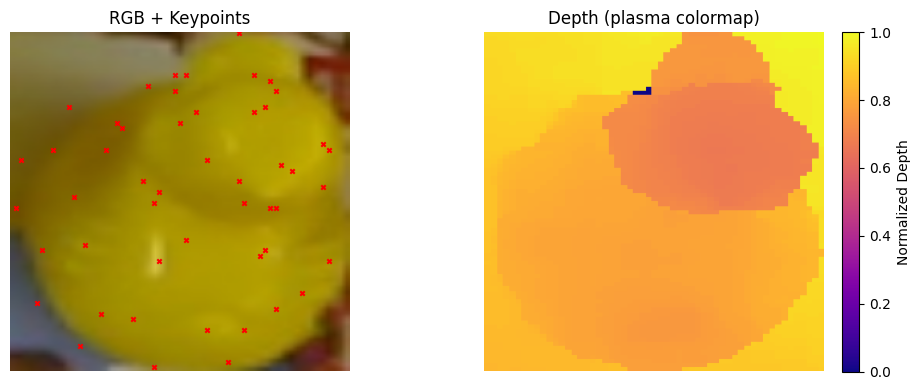

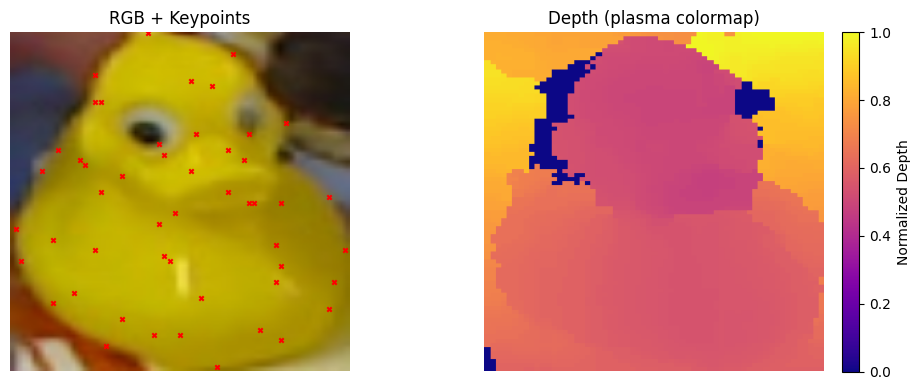

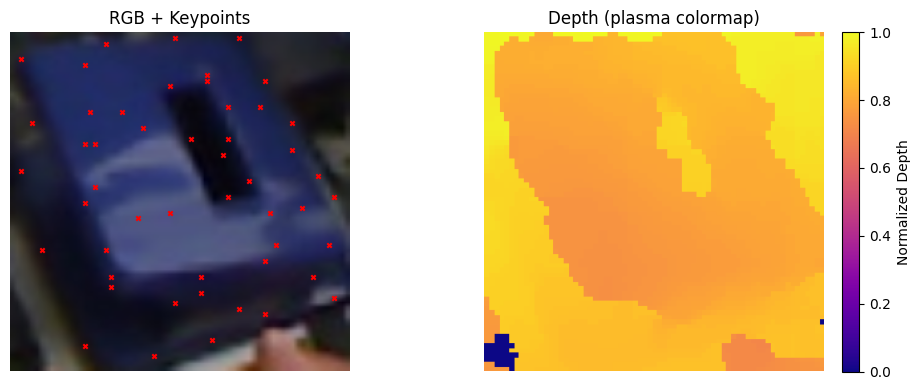

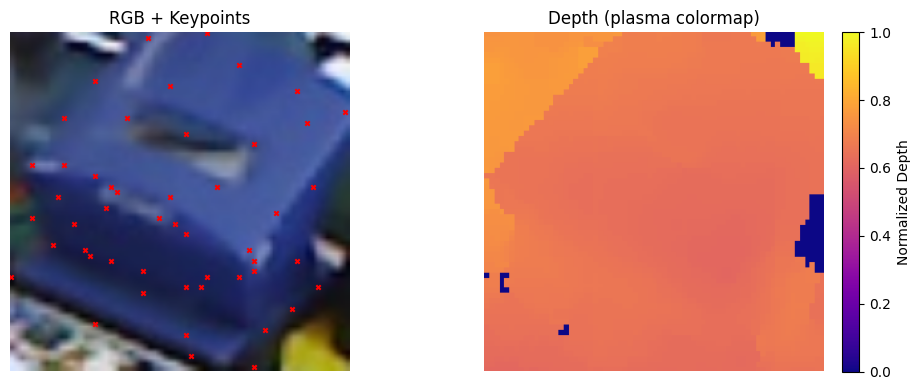

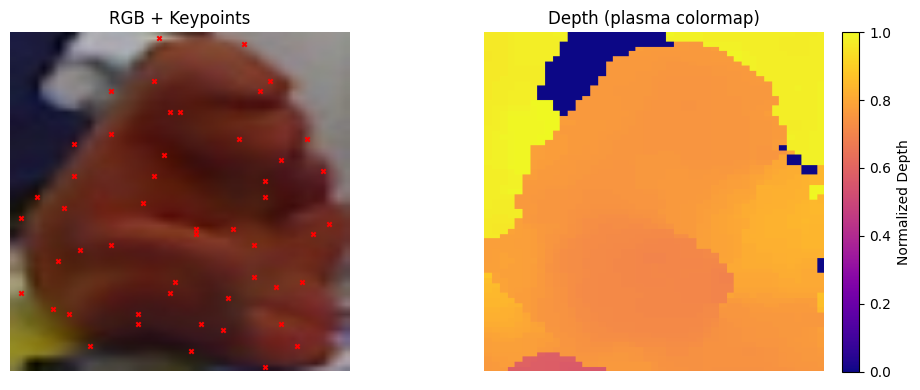

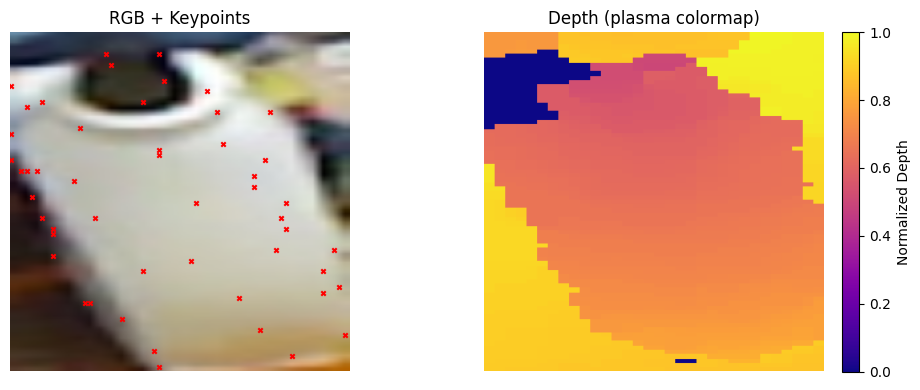

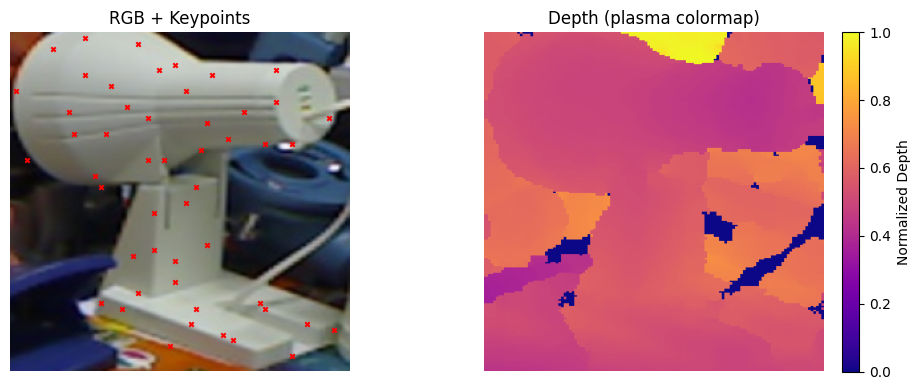

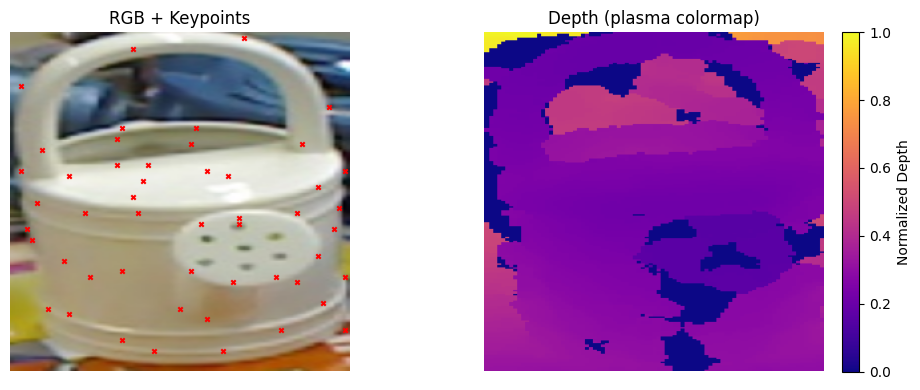

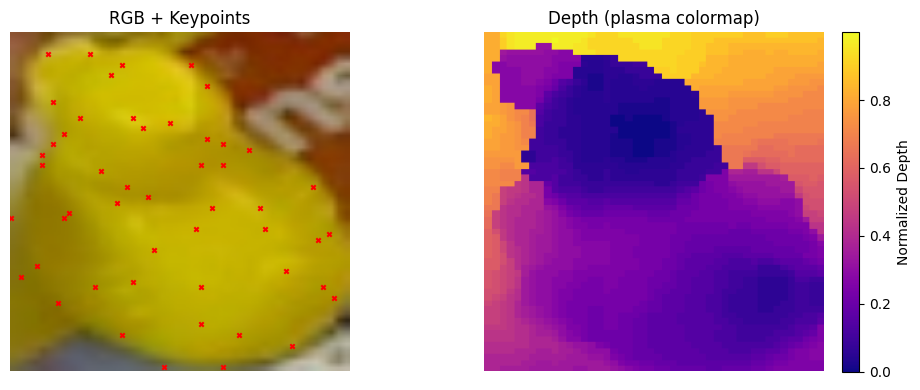

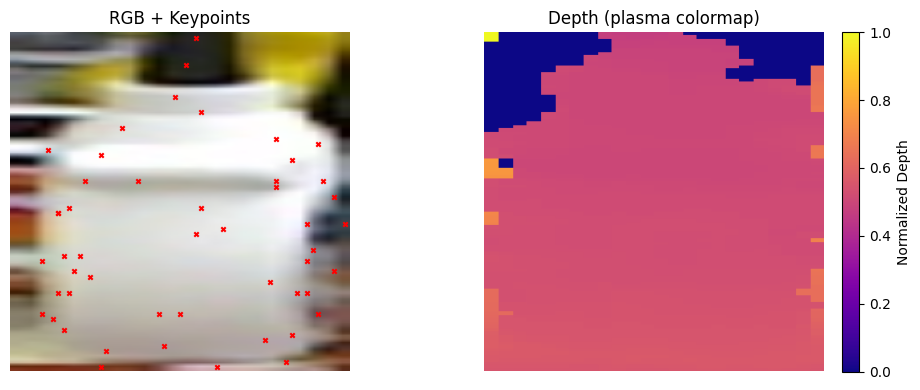

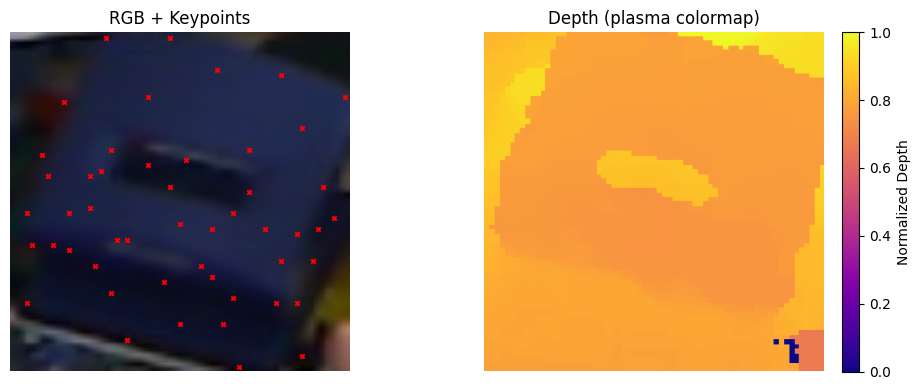

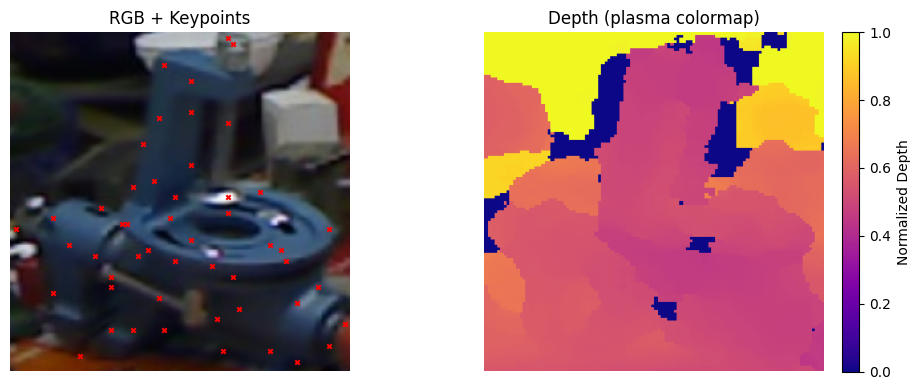

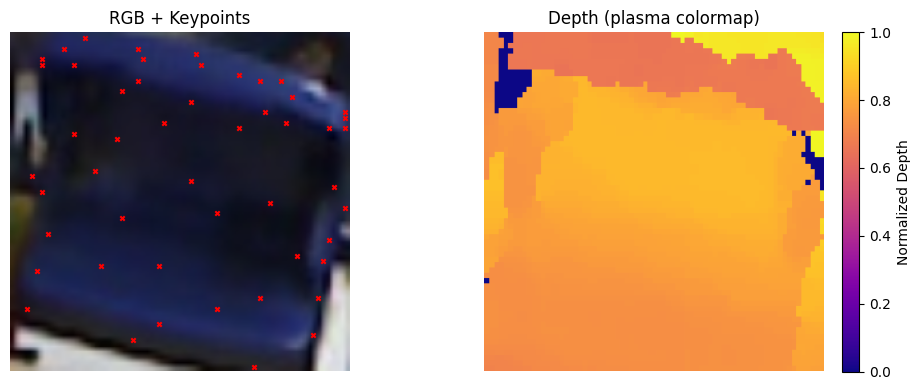

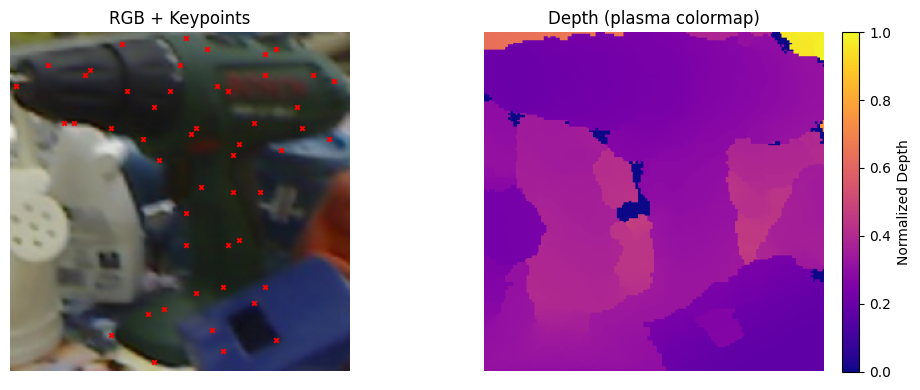

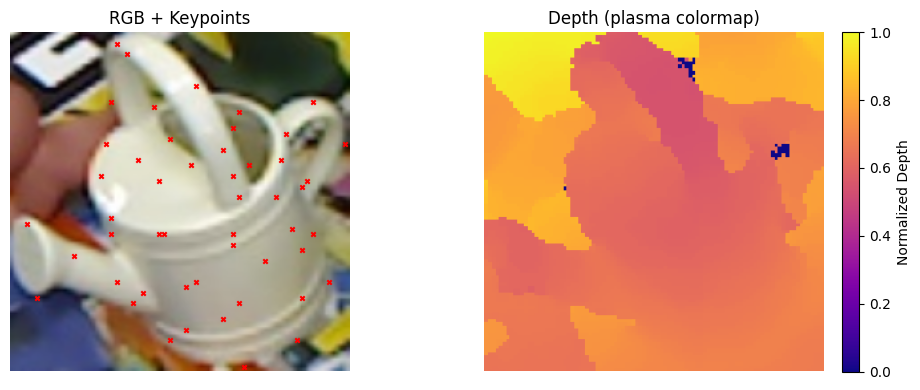

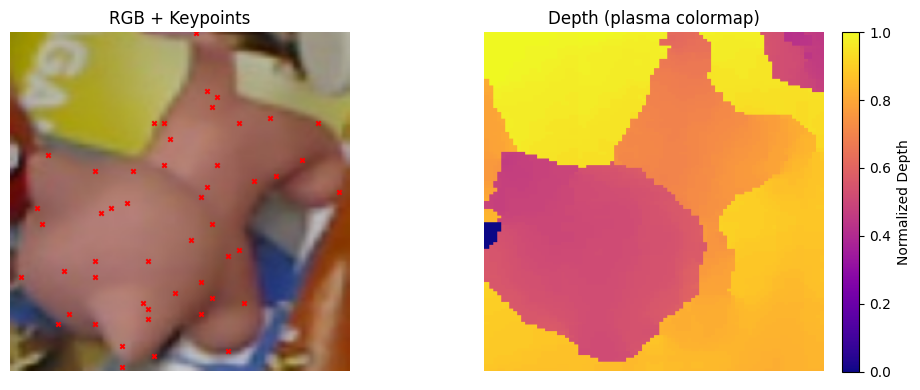

In [ ]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# --- Pretpostavke ---
# imgs:   [B, 3, 256, 256]  (RGB slike)
# depths: [B, 1, 256, 256]  (Depth slike)
# hms:    [B, K, 64, 64]    (Heatmape)

# Normalizacija za denormalizaciju RGB slika
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

# Denormalizuj RGB slike
imgs_denorm = imgs * std + mean

# Skaliranje koordinata iz heatmape (npr. 256 / 64 = 4)
scale = imgs.shape[-1] // hms.shape[-1]

# Funkcija za ekstrakciju koordinata iz heatmape
def get_keypoints_from_heatmaps(hm_np):
    coords = []
    K, H, W = hm_np.shape
    for i in range(K):
        flat_idx = np.argmax(hm_np[i])
        y, x = divmod(flat_idx, W)
        coords.append((x, y))
    return np.array(coords)

# --- Vizualizacija ---
num_examples = min(20, imgs.shape[0])  # prikazi do 20 slika ili koliko ima u batchu

for i in range(num_examples):
    # RGB slika (denormalizovana i konvertovana)
    img = imgs_denorm[i].cpu().permute(1, 2, 0).numpy()
    img = np.clip(img, 0, 1)

    # Depth slika [1, H, W] → [H, W], normalizovana za prikaz
    depth = depths[i][0].cpu().numpy()
    depth_norm = (depth - depth.min()) / (depth.max() - depth.min() + 1e-8)

    # Heatmape i predikcija keypointa
    heatmap = hms[i].cpu().numpy()  # [K, 64, 64]
    keypoints = get_keypoints_from_heatmaps(heatmap)
    keypoints_scaled = keypoints * scale  # skaliraj u 256×256 prostor

    # Plot
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))

    # RGB sa keypoints
    axs[0].imshow(img)
    axs[0].scatter(keypoints_scaled[:, 0], keypoints_scaled[:, 1], c='red', s=10, marker='x')
    axs[0].set_title("RGB + Keypoints")
    axs[0].axis('off')

    # Depth sa colorbarom
    im = axs[1].imshow(depth_norm, cmap='plasma')
    axs[1].set_title("Depth (plasma colormap)")
    axs[1].axis('off')

    # Dodaj colorbar za depth
    fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04, label='Normalized Depth')

    plt.tight_layout()


### Network definition

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models

# ------------------ ResidualBlock ------------------
class ResidualBlock(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.conv1 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += identity
        return self.relu(out)

# ------------------ TwoStageFusion ------------------
class TwoStageFusion(nn.Module):
    def __init__(self, channels):
        super().__init__()
        self.rb1_rgb   = ResidualBlock(channels)
        self.rb1_depth = ResidualBlock(channels)
        self.rb2_rgb   = ResidualBlock(channels)
        self.rb2_depth = ResidualBlock(channels)


    def forward(self, x_rgb, x_depth):
        # 1) svaki branch kroz prvi residual blok
        fbc = self.rb1_rgb(x_rgb)      # F_bc
        fbd = self.rb1_depth(x_depth)  # F_bd

        # 2) cross-sum sa originalnim features
        rgb_in =  fbc + x_depth        # F_bc + F_d
        dpt_in =  fbd + x_rgb          # F_bd + F_c

        # 3) drugi residual blokovi
        out_rgb = self.rb2_rgb(rgb_in)
        out_dpt = self.rb2_depth(dpt_in)

        return torch.cat([out_rgb, out_dpt], dim=1)  # [B, 2*channels, H, W]

class HeatmapHead(nn.Module):
    def __init__(self, num_keypoints, in_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),

            nn.Conv2d(256, num_keypoints, kernel_size=1)
        )

    def forward(self, x):
        x = self.conv(x)
        x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
        return x


class CrossFuNet(nn.Module):
    def __init__(self, num_keypoints=50):
        super().__init__()

        base_rgb = models.resnet18(pretrained=True)
        base_depth = models.resnet18(pretrained=True)

        # Prevent downsampling in layer3 to preserve 32x32 spatial size
        base_rgb.layer3[0].conv1.stride = (1, 1)
        base_rgb.layer3[0].downsample[0].stride = (1, 1)
        base_depth.layer3[0].conv1.stride = (1, 1)
        base_depth.layer3[0].downsample[0].stride = (1, 1)

        self.rgb_encoder   = nn.Sequential(*list(base_rgb.children())[:7])  # up to layer3 (32x32x256)
        self.depth_encoder = nn.Sequential(*list(base_depth.children())[:7])

        self.depth_encoder[0] = nn.Conv2d(1, 64, 7, 2, 3, bias=False)

        self.cross_fusion = TwoStageFusion(256)
        self.decoder = HeatmapHead(num_keypoints=num_keypoints, in_channels=512)  # after fusion: 2*256 = 512

    def forward(self, rgb, depth):
        feat_rgb   = self.rgb_encoder(rgb)
        feat_depth = self.depth_encoder(depth)
        assert feat_rgb.shape[1:] == feat_depth.shape[1:], f"RGB vs Depth feature mismatch: {feat_rgb.shape} vs {feat_depth.shape}"
        fused = self.cross_fusion(feat_rgb, feat_depth)
        assert fused.shape[-2:] == (32,32) and fused.shape[1] == 512, f"Fusion output wrong: {fused.shape}"
        heatmaps = self.decoder(fused)
        assert heatmaps.shape[-2:] == (64,64), f"Head output wrong: {heatmaps.shape}"
        return heatmaps

In [ ]:
# import torch
# import torch.nn as nn
# import torchvision.models as models


# import torch.nn.functional as F

# class HeatmapHeadNovel(nn.Module):
#     def __init__(self, num_keypoints, in_channels):
#         super().__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_channels, 256, kernel_size=3, stride=1, padding=1, bias=False),  # zadržava dimenzije
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1, bias=False),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),

#             nn.Conv2d(256, num_keypoints, kernel_size=1)  # izlaz: [B, K, H, W]
#         )

#     def forward(self, x):
#         x = self.conv(x)  # [B, K, H, W] — npr. H=W=16 ili 32
#         x = F.interpolate(x, size=(64, 64), mode='bilinear', align_corners=False)
#         return x


# # Cross-fusion modul
# class CrossFusionBlockNovel(nn.Module):
#     def __init__(self, channels):
#         super().__init__()
#         self.rgb_resblock = self._make_resblock(channels)
#         self.dpt_resblock = self._make_resblock(channels)

#     def _make_resblock(self, channels):
#         return nn.Sequential(
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(channels),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
#             nn.BatchNorm2d(channels)
#         )

#     def forward(self, f_rgb, f_dpt):
#         r_rgb = self.rgb_resblock(f_rgb)
#         r_dpt = self.dpt_resblock(f_dpt)

#         f_rgb2 = f_rgb + r_dpt
#         f_dpt2 = f_dpt + r_rgb

#         fused = torch.cat([f_rgb2, f_dpt2], dim=1)  # [B, 512, 16, 16]
#         return fused


# class CrossFusionPoseNetNovel(nn.Module):
#     def __init__(self, num_keypoints=21):
#         super().__init__()

#         # RGB ResNet18
#         resnet_rgb = models.resnet18(pretrained=True)
#         self.rgb_conv1 = resnet_rgb.conv1
#         self.rgb_bn1   = resnet_rgb.bn1
#         self.rgb_relu  = resnet_rgb.relu
#         self.rgb_maxpool = resnet_rgb.maxpool
#         self.rgb_layer1 = resnet_rgb.layer1
#         self.rgb_layer2 = resnet_rgb.layer2
#         self.rgb_layer3 = resnet_rgb.layer3

#         # Depth ResNet18 (modifikovan prvi sloj za 1 kanal)
#         resnet_dpt = models.resnet18(pretrained=True)
#         resnet_dpt.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
#         self.dpt_conv1 = resnet_dpt.conv1
#         self.dpt_bn1   = resnet_dpt.bn1
#         self.dpt_relu  = resnet_dpt.relu
#         self.dpt_maxpool = resnet_dpt.maxpool
#         self.dpt_layer1 = resnet_dpt.layer1
#         self.dpt_layer2 = resnet_dpt.layer2
#         self.dpt_layer3 = resnet_dpt.layer3

#         # Višestruki cross-fusion blokovi
#         self.fuse1 = CrossFusionBlockNovel(channels=64)
#         self.fuse2 = CrossFusionBlockNovel(channels=128)
#         self.fuse3 = CrossFusionBlockNovel(channels=256)

#         # Head dobija poslednju fuziju (2×256 = 512)
#         self.head = HeatmapHeadNovel(num_keypoints=num_keypoints, in_channels=512)

#     def forward(self, rgb, depth):
#         # Step 1: conv1
#         x_rgb = self.rgb_relu(self.rgb_bn1(self.rgb_conv1(rgb)))
#         x_dpt = self.dpt_relu(self.dpt_bn1(self.dpt_conv1(depth)))

#         # Step 2: maxpool
#         x_rgb = self.rgb_maxpool(x_rgb)
#         x_dpt = self.dpt_maxpool(x_dpt)

#         # Step 3: layer1 + fusion
#         x_rgb = self.rgb_layer1(x_rgb)
#         x_dpt = self.dpt_layer1(x_dpt)
#         fused1 = self.fuse1(x_rgb, x_dpt)

#         # Step 4: layer2 + fusion
#         x_rgb = self.rgb_layer2(x_rgb)
#         x_dpt = self.dpt_layer2(x_dpt)
#         fused2 = self.fuse2(x_rgb, x_dpt)

#         # Step 5: layer3 + fusion
#         x_rgb = self.rgb_layer3(x_rgb)
#         x_dpt = self.dpt_layer3(x_dpt)
#         fused3 = self.fuse3(x_rgb, x_dpt)

#         # koristi samo poslednji fused output
#         out = self.head(fused3)  # → [B, K, 64, 64]
#         return out



### Training

In [ ]:
from tqdm import tqdm
import torch
import torch.nn as nn


def train_one_epoch(model, train_loader, val_loader, optimizer, criterion, device, epoch, best_val_loss, save_path="best_model.pth"):
    model.train()
    running_loss = 0.0

    train_loop = tqdm(train_loader, desc=f"Epoch {epoch} [Train]", leave=False)
    for rgb, depth, heatmaps_gt in train_loop:
        rgb, depth, heatmaps_gt = rgb.to(device), depth.to(device), heatmaps_gt.to(device)

        optimizer.zero_grad()
        heatmaps_pred = model(rgb, depth)
        loss = criterion(heatmaps_pred, heatmaps_gt)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * rgb.size(0)
        train_loop.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader.dataset)

    model.eval()
    val_loss = 0.0
    val_loop = tqdm(val_loader, desc=f"Epoch {epoch} [Val]", leave=False)
    with torch.no_grad():
        for rgb, depth, heatmaps_gt in val_loop:
            rgb, depth, heatmaps_gt = rgb.to(device), depth.to(device), heatmaps_gt.to(device)
            heatmaps_pred = model(rgb, depth)
            loss = criterion(heatmaps_pred, heatmaps_gt)
            val_loss += loss.item() * rgb.size(0)
            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = val_loss / len(val_loader.dataset)
    print(f"Epoch {epoch} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    # ✅ Dodaj logiku za čuvanje najboljeg modela ovde
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), save_path)
        print(f"✅ Saved best model (val_loss={avg_val_loss:.4f}) at epoch {epoch}")

    return avg_train_loss, avg_val_loss, best_val_loss



In [ ]:
#definition of a loss function
import torch.nn.functional as F

def focal_heatmap_loss(pred, gt, alpha=2.0, gamma=4.0, eps=1e-6):
    """
    pred: raw network output, shape [B,K,H,W]
    gt:   ground-truth heatmaps in [0..1], same shape [B,K,H,W]
    """
    # 1) pretvori output u “confidence” 0..1
    p = torch.sigmoid(pred)

    # 2) positive term: fokus na gt==1 region
    pos = - alpha * (1 - p)**gamma * gt * torch.log(p + eps)

    # 3) negative term: background
    neg = - (1 - gt) * torch.log(1 - p + eps)

    return (pos + neg).mean()

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
print(len(train_loader))

711


In [ ]:
SAVE_PATH = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/models/resnet/best_resnet_fps_model_cross_fusion.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CrossFuNet(num_keypoints=50).to(device)

criterion = focal_heatmap_loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
EPOCHS = 30

best_val_loss = float('inf')

for epoch in range(1, EPOCHS + 1):
    train_loss, val_loss, best_val_loss = train_one_epoch(
        model,
        train_loader,
        val_loader,
        optimizer,
        criterion,
        device,
        epoch,
        best_val_loss,
        save_path=SAVE_PATH
    )


Epoch 1 | Train Loss: 0.1532 | Val Loss: 0.0614
✅ Saved best model (val_loss=0.0614) at epoch 1


Epoch 2 | Train Loss: 0.0515 | Val Loss: 0.0413
✅ Saved best model (val_loss=0.0413) at epoch 2


Epoch 3 | Train Loss: 0.0341 | Val Loss: 0.0289
✅ Saved best model (val_loss=0.0289) at epoch 3


Epoch 4 | Train Loss: 0.0255 | Val Loss: 0.0235
✅ Saved best model (val_loss=0.0235) at epoch 4


Epoch 5 | Train Loss: 0.0213 | Val Loss: 0.0209
✅ Saved best model (val_loss=0.0209) at epoch 5


Epoch 6 | Train Loss: 0.0188 | Val Loss: 0.0191
✅ Saved best model (val_loss=0.0191) at epoch 6


Epoch 7 | Train Loss: 0.0171 | Val Loss: 0.0180
✅ Saved best model (val_loss=0.0180) at epoch 7


Epoch 8 | Train Loss: 0.0158 | Val Loss: 0.0170
✅ Saved best model (val_loss=0.0170) at epoch 8


Epoch 9 | Train Loss: 0.0149 | Val Loss: 0.0163
✅ Saved best model (val_loss=0.0163) at epoch 9


Epoch 10 | Train Loss: 0.0142 | Val Loss: 0.0161
✅ Saved best model (val_loss=0.0161) at epoch 10


Epoch 11 | Train Loss: 0.0136 | Val Loss: 0.0153
✅ Saved best model (val_loss=0.0153) at epoch 11


Epoch 12 | Train Loss: 0.0131 | Val Loss: 0.0150
✅ Saved best model (val_loss=0.0150) at epoch 12


Epoch 13 | Train Loss: 0.0127 | Val Loss: 0.0146
✅ Saved best model (val_loss=0.0146) at epoch 13


Epoch 14 | Train Loss: 0.0124 | Val Loss: 0.0145
✅ Saved best model (val_loss=0.0145) at epoch 14


Epoch 15 | Train Loss: 0.0121 | Val Loss: 0.0140
✅ Saved best model (val_loss=0.0140) at epoch 15


Epoch 16 | Train Loss: 0.0119 | Val Loss: 0.0139
✅ Saved best model (val_loss=0.0139) at epoch 16


Epoch 17 | Train Loss: 0.0116 | Val Loss: 0.0138
✅ Saved best model (val_loss=0.0138) at epoch 17


Epoch 18 | Train Loss: 0.0114 | Val Loss: 0.0138
✅ Saved best model (val_loss=0.0138) at epoch 18


Epoch 19 | Train Loss: 0.0113 | Val Loss: 0.0138


Epoch 20 | Train Loss: 0.0111 | Val Loss: 0.0136
✅ Saved best model (val_loss=0.0136) at epoch 20


Epoch 21 | Train Loss: 0.0110 | Val Loss: 0.0135
✅ Saved best model (val_loss=0.0135) at epoch 21


Epoch 22 | Train Loss: 0.0109 | Val Loss: 0.0134
✅ Saved best model (val_loss=0.0134) at epoch 22


Epoch 23 | Train Loss: 0.0107 | Val Loss: 0.0133
✅ Saved best model (val_loss=0.0133) at epoch 23


Epoch 24 | Train Loss: 0.0106 | Val Loss: 0.0132
✅ Saved best model (val_loss=0.0132) at epoch 24


Epoch 25 | Train Loss: 0.0106 | Val Loss: 0.0134


Epoch 26 | Train Loss: 0.0105 | Val Loss: 0.0133


Epoch 27 | Train Loss: 0.0104 | Val Loss: 0.0131
✅ Saved best model (val_loss=0.0131) at epoch 27


Epoch 28 | Train Loss: 0.0103 | Val Loss: 0.0131
✅ Saved best model (val_loss=0.0131) at epoch 28


Epoch 29 | Train Loss: 0.0102 | Val Loss: 0.0131
✅ Saved best model (val_loss=0.0131) at epoch 29


Epoch 30 | Train Loss: 0.0102 | Val Loss: 0.0130
✅ Saved best model (val_loss=0.0130) at epoch 30


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# --- 1. Ekstrakcija koordinata iz heatmapi ---
def get_keypoints_from_heatmaps(hm_np):
    """
    Input: heatmap numpy array [K, H, W]
    Output: keypoints [K, 2] with (x, y) in heatmap space
    """
    K, H, W = hm_np.shape
    coords = []
    for i in range(K):
        yx = np.unravel_index(np.argmax(hm_np[i]), (H, W))
        coords.append((yx[1], yx[0]))  # (x, y)
    return np.array(coords)


# --- 2. Denormalizuj RGB sliku ---
def denormalize_rgb(img_tensor):
    """
    img_tensor: [3, H, W] normalized image
    returns: numpy image [H, W, 3] in [0,1]
    """
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    img = img_tensor * std + mean
    img = img.permute(1, 2, 0).cpu().numpy()
    return np.clip(img, 0, 1)


# --- 3. Vizualizuj RGB sliku sa GT i predikcijama ---
def visualize_prediction(rgb_tensor, gt_hm, pred_hm, scale=4):
    """
    rgb_tensor: [3, 256, 256]
    gt_hm: [K, 64, 64]
    pred_hm: [K, 64, 64]
    """
    if isinstance(gt_hm, torch.Tensor): gt_hm = gt_hm.cpu().numpy()
    if isinstance(pred_hm, torch.Tensor): pred_hm = pred_hm.cpu().numpy()

    gt_pts = get_keypoints_from_heatmaps(gt_hm) * scale
    pr_pts = get_keypoints_from_heatmaps(pred_hm) * scale
    img_np = denormalize_rgb(rgb_tensor)

    plt.figure(figsize=(5, 5))
    plt.imshow(img_np)
    plt.scatter(gt_pts[:, 0], gt_pts[:, 1], c='lime', marker='o', label='GT')
    plt.scatter(pr_pts[:, 0], pr_pts[:, 1], c='red', marker='x', label='Pred')
    plt.title("Predikovani vs. GT keypointi")
    plt.axis('off')
    plt.legend(loc='lower right')
    plt.show()


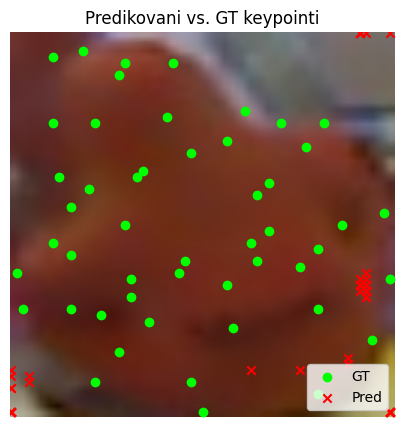

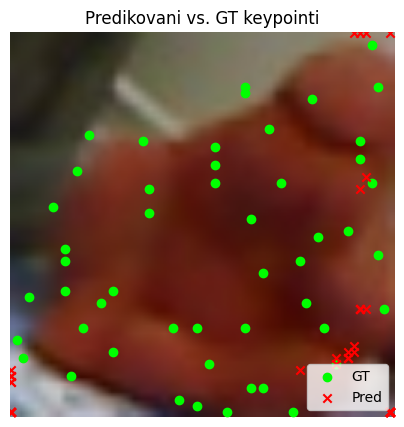

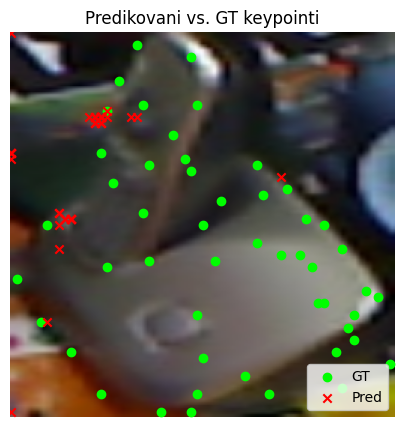

In [ ]:
# model.load_state_dict(torch.load(.pth", map_location=device))
# model.to(device)
# model.eval()


# imgs, depths, gt_maps = next(iter(val_loader))
# imgs, depths, gt_maps = imgs[:3], depths[:3], gt_maps[:3]

# with torch.no_grad():
#     preds = model(imgs.to(device), depths.to(device)).cpu()

# for i in range(3):
#     visualize_prediction(
#         rgb_tensor=imgs[i],
#         gt_hm=gt_maps[i],
#         pred_hm=preds[i],
#         scale=imgs.shape[2] // gt_maps.shape[2]
#     )


In [ ]:
import os
import json
import torch



model.load_state_dict(torch.load(SAVE_PATH, map_location=device))
model.to(device)
model.eval()

def get_all_keypoints(preds, hmap_size=64, img_size=256):
    B, K, H, W = preds.shape
    scale = img_size / hmap_size
    offset = scale / 2
    preds = preds.cpu()
    all_results = []

    for b in range(B):
        heatmaps = preds[b]  # [K, H, W]
        pts = []
        for idx in range(K):
            hm = heatmaps[idx]
            flat = hm.view(-1)
            pos = flat.argmax().item()
            y, x = divmod(pos, W)
            x = x * scale + offset
            y = y * scale + offset
            pts.append([float(x), float(y)])  # JSON-friendly format
        all_results.append(pts)

    return all_results

# Dataset reference info
subset     = val_loader.dataset            # Subset
orig_ds    = subset.dataset                # Original KeypointHeatmapDataset
indices    = subset.indices                # Map subset index to global
batch_size = val_loader.batch_size

# Dict for predictions
predictions = {}

# Loop kroz sve validacione primere
for batch_i, (rgb_imgs, dpt_imgs, _) in enumerate(val_loader):
    rgb_imgs = rgb_imgs.to(device)
    dpt_imgs = dpt_imgs.to(device)

    with torch.no_grad():
        preds = model(rgb_imgs, dpt_imgs).cpu()

    batch_keypoints = get_all_keypoints(preds)

    for i, pts in enumerate(batch_keypoints):
        global_idx = indices[batch_i * batch_size + i]
        img_id = orig_ds.basenames[global_idx]
        predictions[img_id] = pts

# Ekspurtuj kao JSON
# os.makedirs(out_dir, exist_ok=True)

out_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points"
os.makedirs(out_dir, exist_ok=True)
out_path = os.path.join(out_dir, "2D_fps_keypoints_cross_fusion_ext.json")

with open(out_path, "w") as f:
    json.dump(predictions, f, indent=2, sort_keys=True)

print(f"✅ Saved {len(predictions)} keypoint predictions to {out_path}")


✅ Saved 2843 keypoint predictions to /content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/predicted_key_points/2D_fps_keypoints_cross_fusion_ext.json


## Plot results

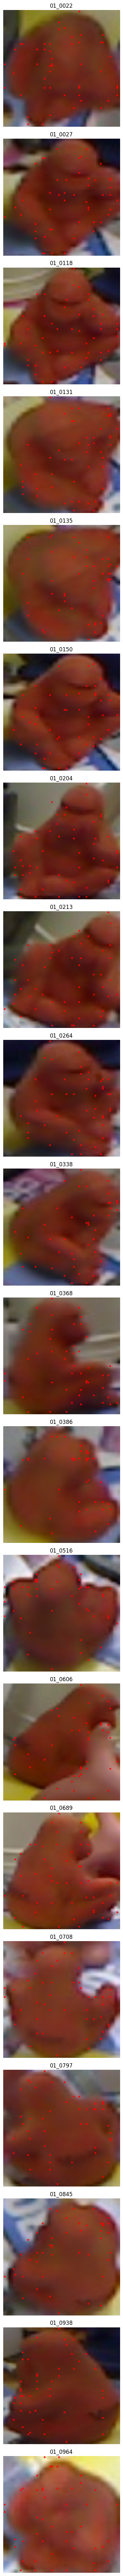

In [ ]:
import matplotlib.pyplot as plt
import torch
import json
import os
import numpy as np
from PIL import Image

# Putanja do JSON fajla sa predikcijama
json_path = "2D_fps_keypoints_crossfusion.json"

# Folder sa originalnim RGB slikama
image_dir = "/content/drive/MyDrive/MLDL/6D-Pose-Estimation/data/mini_data/cropped_resized_images"

# Koliko slika želiš da vizualizuješ
n = 20  # preporučeno manji broj, 100 je previše za jedan prikaz

# Učitaj predikcije
with open(json_path, "r") as f:
    predictions = json.load(f)

# Prvih n slika
img_ids = list(predictions.keys())[:n]

# Plotovanje (vertikalno)
fig, axs = plt.subplots(n, 1, figsize=(6, 4 * n))  # širina 6, visina 4 po slici
if n == 1:
    axs = [axs]

for i, img_id in enumerate(img_ids):
    img_path = os.path.join(image_dir, img_id + ".png")
    img = Image.open(img_path).convert("RGB")
    img_np = np.array(img)

    keypoints = np.array(predictions[img_id])  # [K, 2]

    axs[i].imshow(img_np)
    axs[i].scatter(keypoints[:, 0], keypoints[:, 1], c='red', s=10, marker='x')
    axs[i].set_title(img_id)
    axs[i].axis('off')

plt.tight_layout()
plt.show()
